# Trial Completion Event Study

Visualize stock price movement around clinical trial completion dates.

Enter a sponsor name below and run the cells to fetch fresh data, or leave blank to load the most recent analysis.

In [ ]:
# Enter sponsor name to run fresh analysis (leave empty to load most recent)
SPONSOR_NAME = ""  # e.g. "AstraZeneca", "Celldex Therapeutics", "Eli Lilly and Company"

In [1]:
import json
import os
import sys
import polars as pl
from pathlib import Path
import matplotlib.pyplot as plt

# Add parent dir to path for imports
sys.path.insert(0, str(Path('.').resolve().parent))

plt.style.use('seaborn-v0_8-whitegrid')

In [9]:
# Run fresh analysis or load existing data
output_dir = Path('output')

if SPONSOR_NAME.strip():
    # Run fresh analysis for the specified sponsor
    print(f'Running analysis for sponsor: {SPONSOR_NAME}')
    from trial_stock_impact import main as run_analysis
    df, metadata = run_analysis(SPONSOR_NAME.strip())
    
    ticker = metadata['ticker']
    event_date = metadata['event_date']
    trial = metadata.get('trial', {})
    print(f'\nLoaded fresh data for {ticker}')
else:
    # Load the most recent event study output
    parquet_files = sorted(output_dir.glob('*_event_study.parquet'))
    
    if not parquet_files:
        raise FileNotFoundError('No event study files found. Set SPONSOR_NAME or run trial_stock_impact.py first.')
    
    latest = parquet_files[-1]
    print(f'Loading cached: {latest.name}')
    
    # Parse ticker and date from filename
    parts = latest.stem.replace('_event_study', '').rsplit('_', 1)
    ticker, event_date = parts[0], parts[1]
    
    # Load data
    df = pl.read_parquet(latest)
    
    # Load metadata if available
    metadata_path = latest.with_name(latest.stem + '_metadata.json')
    metadata = {}
    if metadata_path.exists():
        with open(metadata_path) as f:
            metadata = json.load(f)
    
    trial = metadata.get('trial', {})

print(f'Ticker: {ticker} ({metadata.get("company_name", "N/A")})')
print(f'Event Date: {event_date}')

Loading: LLY_2026-01-19_event_study.parquet
Ticker: LLY (Eli Lilly & Co.)
Event Date: 2026-01-19


In [10]:
# Trial Details
if trial:
    print('=== Trial Details ===')
    print(f"NCT ID:       {trial.get('nct_id', 'N/A')}")
    print(f"Phase:        {trial.get('phase', 'N/A')}")
    print(f"Enrollment:   {trial.get('enrollment_count', 'N/A')} ({trial.get('enrollment_type', '')})")
    print(f"Study Type:   {trial.get('study_type', 'N/A')}")
    print(f"Conditions:   {', '.join(trial.get('conditions', []))}")
    print(f"Has Results:  {trial.get('has_results', False)}")
    print(f"\nTitle: {trial.get('brief_title', 'N/A')}")
else:
    print('No trial metadata available - run with SPONSOR_NAME to fetch')

=== Trial Details ===
NCT ID:      NCT06916065
Phase:       PHASE1
Enrollment:  188 (ACTUAL)
Study Type:  INTERVENTIONAL
Conditions:  Overweight, Obesity
Has Results: False

Title: A Study of Eloralintide (LY3841136) and Eloralintide With Tirzepatide in Participants With Overweight or Obesity


In [4]:
# Preview price data
df.head(10)

date,o,h,l,c,v,vw,daily_return_pct,days_from_event,cumulative_return_pct
datetime[ms],f64,f64,f64,f64,f64,f64,f64,i64,f64
2025-12-22 05:00:00,1076.72,1083.48,1063.0,1076.48,2.625621e6,1072.0969,null,-28,3.66718
2025-12-23 05:00:00,1063.5,1088.48,1063.5,1071.64,2.108561e6,1074.0326,-0.449614,-27,3.201079
2025-12-24 05:00:00,1074.64,1085.73,1072.71,1076.98,932804.0,1077.1961,0.498302,-26,3.715331
2025-12-26 05:00:00,1076.98,1081.39,1068.3,1077.75,1.01464e6,1075.0686,0.071496,-24,3.789484
2025-12-29 05:00:00,1077.95,1085.5,1074.38,1078.73,1.653011e6,1080.9022,0.09093,-21,3.88386
2025-12-30 05:00:00,1078.96,1082.37,1072.07,1079.75,1.251498e6,1078.9139,0.094556,-20,3.982088
2025-12-31 05:00:00,1079.76,1083.5,1074.43,1074.68,1.646696e6,1076.9739,-0.469553,-19,3.493837
2026-01-02 05:00:00,1076.4,1080.66,1052.08,1080.36,2.469097e6,1072.5235,0.528529,-17,4.040832
2026-01-05 05:00:00,1069.23,1085.38,1033.3801,1041.51,4.084836e6,1044.9872,-3.596024,-14,0.299499


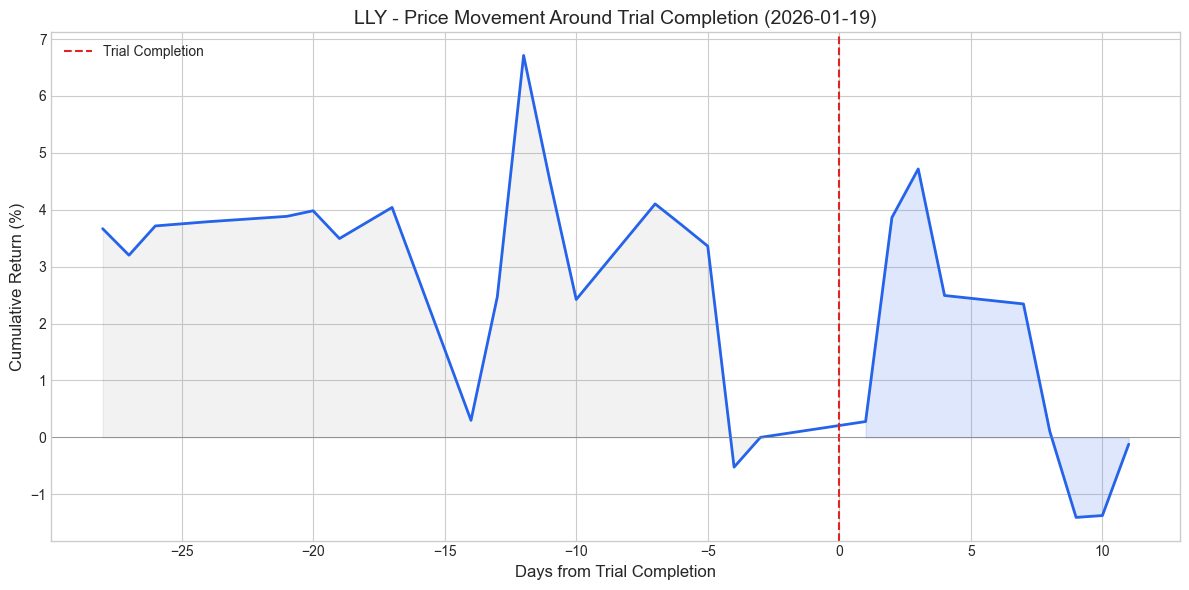

In [5]:
# Cumulative return plot around event
fig, ax = plt.subplots(figsize=(12, 6))

days = df['days_from_event'].to_list()
cum_ret = df['cumulative_return_pct'].to_list()

ax.plot(days, cum_ret, linewidth=2, color='#2563eb')
ax.axvline(x=0, color='#dc2626', linestyle='--', linewidth=1.5, label='Trial Completion')
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)

ax.fill_between(days, cum_ret, 0, where=[d >= 0 for d in days], alpha=0.15, color='#2563eb')
ax.fill_between(days, cum_ret, 0, where=[d < 0 for d in days], alpha=0.1, color='gray')

ax.set_xlabel('Days from Trial Completion', fontsize=12)
ax.set_ylabel('Cumulative Return (%)', fontsize=12)
ax.set_title(f'{ticker} - Price Movement Around Trial Completion ({event_date})', fontsize=14)
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [6]:
# Summary statistics
pre_event = df.filter(pl.col('days_from_event') < 0)
post_event = df.filter(pl.col('days_from_event') >= 0)

print('=== Event Study Summary ===')
print(f'Ticker: {ticker}')
print(f'Event Date: {event_date}')
print(f'Data Range: {df["date"].min()} to {df["date"].max()}')
print()

if not pre_event.is_empty():
    print(f'Pre-event window: {len(pre_event)} trading days')
    print(f'  Cumulative return: {pre_event["cumulative_return_pct"][-1]:.2f}%')
    print(f'  Avg daily return: {pre_event["daily_return_pct"].mean():.3f}%')
    print(f'  Volatility (std): {pre_event["daily_return_pct"].std():.3f}%')
print()

if not post_event.is_empty():
    print(f'Post-event window: {len(post_event)} trading days')
    print(f'  Cumulative return: {post_event["cumulative_return_pct"][-1]:.2f}%')
    print(f'  Avg daily return: {post_event["daily_return_pct"].mean():.3f}%')
    print(f'  Volatility (std): {post_event["daily_return_pct"].std():.3f}%')

=== Event Study Summary ===
Ticker: LLY
Event Date: 2026-01-19
Data Range: 2025-12-22 05:00:00 to 2026-01-30 05:00:00

Pre-event window: 18 trading days
  Cumulative return: 0.00%
  Avg daily return: -0.194%
  Volatility (std): 1.947%

Post-event window: 9 trading days
  Cumulative return: -0.12%
  Avg daily return: 0.001%
  Volatility (std): 1.828%


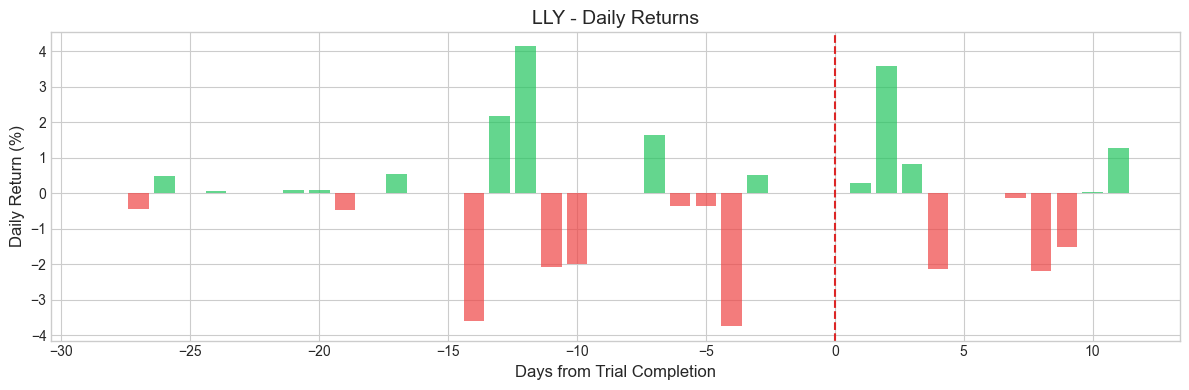

In [11]:
# Daily returns bar chart
fig, ax = plt.subplots(figsize=(12, 4))

# Handle None values from shift calculation
daily_returns = df['daily_return_pct'].fill_null(0).to_list()
colors = ['#22c55e' if r > 0 else '#ef4444' for r in daily_returns]
ax.bar(days, daily_returns, color=colors, alpha=0.7, width=0.8)
ax.axvline(x=0, color='#dc2626', linestyle='--', linewidth=1.5)

ax.set_xlabel('Days from Trial Completion', fontsize=12)
ax.set_ylabel('Daily Return (%)', fontsize=12)
ax.set_title(f'{ticker} - Daily Returns', fontsize=14)

plt.tight_layout()
plt.show()